# COVID-19 DISCOVERY ASSISTANT
#### COVID-19 DISCOVERY ASSISTANT is a dynamic semantic search interface for discovering sentences that are related to COVID-19 vaccines and therapeutics.The following scripts extract related sentences from PMC disucssion sections using COVID-19 word embeddings. Publishing dates and affiliations locations were then used to visualise COVID-19 research efforts all over the world.  The interface is a modified version of the "Events Discovery Assistant" that was created for discovering First World War Events (https://ieeexplore.ieee.org/document/7889570). The interface will be available Next Monday on http://semantics-global.de/index.php/covid-19 (I'm experiencing memory allocation issues)

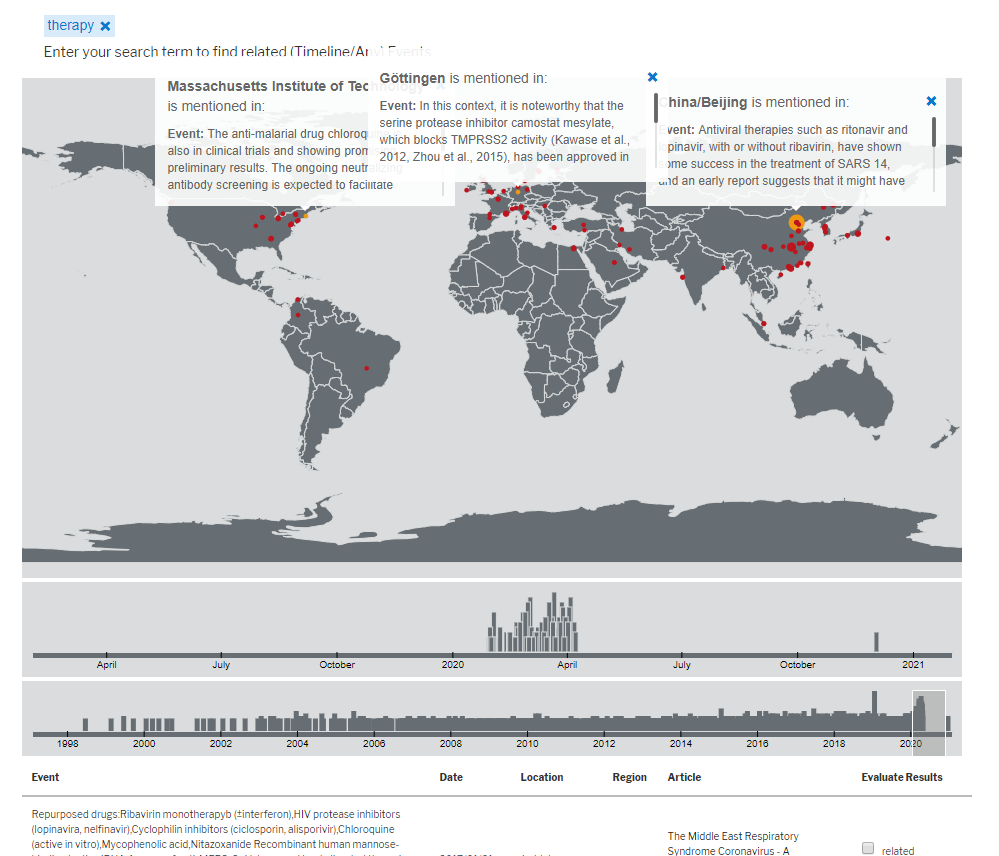

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
import re
import os
import string
import random
import json
import sys
import spacy #pip install -U spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")#python -m spacy download en_core_web_sm
#sci = spacy.load("en_core_sci_md")
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models.keyedvectors import KeyedVectors
import requests
from pathlib import Path
from scipy.spatial import distance
from ast import literal_eval
#med7 = spacy.load("en_core_med7_lg")#https://github.com/kormilitzin/med7

In [ ]:
### paths ###
word2vecdir = '/kaggle/input/covidw2v/covid_w2v/' #word2vec dir
csvdir = '/kaggle/input/covid19texts/'# pubmed open access csv dir
jsondirs = ['/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/']# kaggle common_use pmc dir

In [ ]:
### Retrieving Kaggle data PMC IDs from common_use_subset directory ###
kpmcids =[]
for jsondir in jsondirs:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:       
            if filename.endswith('.json'):
                jfile = os.path.join(dirname, filename)
                #print(jfile)
                with open(os.path.join(jsondir, jfile)) as json_file:
                    vjson = json.load(json_file)
                    if 'PMC'in vjson['paper_id']:
                        kpmcids.append(vjson['paper_id'])           
                        

#### Open Access (OA) full texts were retrieved using the following query in PubMed:
##### ("COVID-19" OR "coronavirus disease 2019" OR "SARS-CoV-2" OR "coronavirus 2" OR "Coronavirus Infections")AND("Physiology" OR "Metabolism" OR "genetics" OR "virology" OR "Pathogenicity" OR "Transmission" OR "Immunology" OR "Chemistry" OR "Therapy" OR "Diagnosis" OR "isolation and purification" OR "vaccination" OR "pre-exposure prophylaxis" OR "post-exposure prophylaxis" OR "health personnel" OR "drug design" OR "drug resistance viral" OR "antiviral agents" OR "Antibodies Neutralizing" OR "therapeutic use" OR "Risk Factors" OR "cell survival" OR "animals" OR "viral vaccines").
#### Then, OA full texts XMLs were retrieved using EuropePMC API services and parsed as texts


In [ ]:
### LOADING OPEN ACCESS PUBMED TEXTS ###
csvf = os.path.join(csvdir,'covid-19-texts.csv')
print(csvf)
data = pd.read_csv(csvf)
data.fillna(0,inplace=True)
data

In [ ]:
### filtering pubmed texts to include those from kaggle only [N=1265] ###
data = data[data['PMC'].isin(kpmcids)]
pmcs = list(data['PMC'])
data

In [ ]:
### filter data to those published in 2019 and 2020 only ###
#cdates = ['2019','2020']
#data['cDATE'] = [d for d in data['DATE']]
#data['cDATE'] = ['Y' if '2020' in d or '2019' in d else 'N' for d in data['cDATE']]
#data = data[data['cDATE']!='N']

In [ ]:
### filtering data to those containing corona in their abstracts ###
data['cTOPIC'] = [d for d in data['TITLE']]
data['cTOPIC'] = ['Y' if 'corona' or 'sar-cov' or 'covid' in str(d) else 'N' for d in data['ABS']]
data = data[data['cTOPIC']!='N']
pmcs = list(data['PMC'])

In [ ]:
data

In [ ]:
### generating sentences from text ###
stopwords = nltk.corpus.stopwords.words('english')
all_sents_words = []
all_sents = []
for t, txt in enumerate(data['text']):    
    sents = nltk.sent_tokenize(txt)      
    for sent in sents:
        words = nltk.word_tokenize(sent)                 
        words = [word for word in words if word.lower() not in stopwords and word.lower() not in string.punctuation]
        all_sents_words.append(words)
        all_sents.append([pmcs[t],sent])

In [ ]:
### Bag of words covering kaggle challenge topics ###
cents = {}
cents['studies'] = ['naproxen clarithromycin minocyclinethat','viral inhibitor']
cents['ADE'] = ['Antibody-Dependent Enhancement (ADE)']
cents['animal'] = ['animal','model']
cents['therapy'] = ['IL-6 camostat mesylate chloroquine hydroxychloroquine lopinavir ritonavir ivermectin remdesivir heparin','antiviral agent','monclonal antibodies viral','convalscent plasma']
cents['decision'] = ['therapeutics production','decision making','model']
cents['vaccine'] = ['vaccine','universal','covid-19']
cents['prophylaxis'] = ['prophylaxis','health care workers']
cents['risk'] = ['adverse effects','potential complication','vaccine']
cents['assay'] = ['assays','immune response','vaccine development','animal model','therapeutics']
cents['transmission'] = ['transmission']
cents['pathogenesis'] = ['spike glycoprotein','Antigen','Receptor']
cents['symptoms'] = ['symptoms']
cents['immunity'] = ['Cytokines Interleukins Interferon Antibodies CD4 CD8','Immunity']
cents['diagnosis'] = ['ELISA RT-PCR Western blot immunofluorescence radiography','diagnostic','kits','autopsy','assay','lung-derived cells','serodiagnosis','serology','virus isolation','specimens','cell culture']

### topics of interest ###
catgs = list(cents.keys())

#### Word embeddings were generated from training OA PMC full texts. 

In [ ]:
### Word embeddings models ###
fast_embeds = ['ncbi_corona_TAGD_WV_fasttext_200_5.model']
fast_ttls = ['fasttext_200_5']

In [ ]:
vdfgs = {}
### scanning discussion sections for topic-related sentences ###
for n,m in enumerate(fast_embeds):    
    model = Word2Vec.load(word2vecdir+m)
    wv = KeyedVectors.load(word2vecdir+m)
    #vsdfs =[]    
    for j, v in enumerate(catgs): 
        #print(j)
        #print(v)
        vcol1 = []
        vcol2 = []
        vcol3 = []
        vcol4 = []
        vcol5 = []
        vcol6 = []
                
        ### generating topic embeddings ###
        syns = cents[catgs[j]]         
        syns_avec = wv[' '.join(cents[catgs[j]])] # topic words representations (embeddings)
        
        ### retrieving topic-related sentences ###
        vsdsts = []        
        vwords = []
        for s,sent in enumerate(all_sents_words):            
            asent_vec = wv[' '.join(sent)] # sentence words representations (embeddings)
            sdst = np.around(distance.cosine(syns_avec,asent_vec),decimals=2) # 
            vsdsts.append(sdst)
            wdsts = [distance.cosine(wv[cents[catgs[j]][0]],wv[word]) for word in sent]
            sort_wdsts_keys = np.argsort(wdsts)
            sort_wdsts ={sent[i]:np.around(wdsts[i],decimals=2) for i in sort_wdsts_keys if np.around(wdsts[i],decimals=2)<0.5}   
            vwords.append(sort_wdsts)
        sort_vsdsts_keys = np.argsort(vsdsts)
        for i in sort_vsdsts_keys:
            if vsdsts[i]<0.5:
                pmcid = all_sents[i][0]
                vcol1.append(pmcid)
                vcol2.append(all_sents[i][1])
                vcol3.append(vsdsts[i])
                vcol4.append(vwords[i])
                vcol5.append(list(data[data['PMC'] == pmcid]['DATE'])[0]) if list(data[data['PMC'] == pmcid]['DATE'])!=[] else vcol5.append('')
                vcol6.append(list(data[data['PMC'] == pmcid]['AFF'])[0]) if list(data[data['PMC'] == pmcid]['AFF'])!=[] else vcol6.append('')
        vdf = pd.DataFrame([vcol1,vcol2,vcol3,vcol4,vcol5,vcol6]).transpose()
        vdf.columns = ['PMC-ID','SENT','COS-SIM','ENTITY','DATE','AFF']
        vdf.columns = ['PMC-ID','SENT','COS-SIM','ENTITY','DATE','AFF']
        vdfg1 = vdf.groupby(['PMC-ID'],sort=False)['SENT'].apply(list).reset_index()
        vdfg2 = vdf.groupby(['PMC-ID'],sort=False)['DATE'].apply(list).reset_index()
        vdfg3 = vdf.groupby(['PMC-ID'],sort=False)['ENTITY'].apply(list).reset_index()
        vdfg4 = vdf.groupby(['PMC-ID'],sort=False)['AFF'].apply(list).reset_index()
        vdfg = vdfg1.join(vdfg2['DATE']).join(vdfg3['ENTITY']).join(vdfg4['AFF'])
        vdfg['DATE'] = [d[0] for d in vdfg['DATE']] # cleaning date column
        vdfg['AFF'] = [d[0] for d in vdfg['AFF']] # cleaning affiliation column
        vdfg['ENTITY'] = [list(np.unique([enk for ents in entss for enk in list(ents.keys())])) for entss in vdfg['ENTITY']] # cleaning entities column        
        vdfgs[v] = vdfg            

In [ ]:
### Animal models tried with coronaviruses ###
for n,m in enumerate(vdfgs['animal']):
    row = vdfgs['animal'].iloc[n+1]
    print(row['PMC-ID'])
    print(' ')
    print(' ')
    print(row['SENT'][0:5])
    print(' ')
    print('###################################')
    print(' ')

### PMC6307849
 
['in mouse model.', 'Limited by biosafety regulations, we are not qualified to test if immunization with Rv3615c could protect mice from a virulent M.tb challenge, and the potential of inducing sustainable adaptive immunity in humans requires further clinical study.', 'We believe that our data provide information to support further investigation of the Rv315c as a vaccine candidate delivered by alternative routes.']

 
### PMC4525294 
 
['In this model, Zhao et al.', 'Recently, two other animal challenge models have been reported in immunized mice.', 'A potentially more sustainable transgenic lethal mouse model reported by Agrawal et al.', 'In addition, the JordanN3 strain used to challenge the NHPs may have been less virulent than the EMC strain used in other challenge studies of rhesus macaques.', 'In the context of MERS-CoV, this is also the first time that a combination of DNA and protein immunogens has been tested in an animal model and the first time any immunization regimen has been evaluated and demonstrated protection in NHPs, with the caveats mentioned below.']

 
### PMC3256233
 
['This issue can be addressed only in Mcl-1 knockout mouse or other suitable animal models.']

 
### PMC6315345
 
['So far, there is a lack of appropriate animal models to mimic the pathology of MERD-CoV in humans.', 'With robust animal models, the protective effects of these neutralizing mAbs will be better evaluated.', 'Furthermore, ongoing efforts on developing therapeutic neutralizing mAbs against MERS-CoV should also consider the different target populations (dromedary camels and humans) and their protective efficacy.', 'Commonly-used laboratory animals—such as wild-type mouse, ferret, hamster, and guinea pig—are not susceptible to MERS-CoV infection due to differences in critical amino acids in the S-binding domain of their DPP4 [41,42,43].', 'New Zealand rabbits, hDPP4-transduced/transgenic mice, camelids and non-human primates (rhesus macaque and common marmoset) are susceptible to MERS-CoV infection, however, rabbits showed asymptomatic infection [44]; dromedary camels displayed different clinical manifestations to that of humans [45]; rhesus macaque only showed transient lower respiratory infection [46], while common marmoset developed progressive pneumonia [47]; hDPP4-trangenic mouse expressed hDPP4 extensively, and resulted in multiple organ damage [48]; hDPP4-transduced mouse only exhibited mild transient clinical diseases [19].']

 
### PMC7107340
 
['Our studies have tested mouse, ferret, and guinea pig models and found these animals are not susceptible to MERS-CoV (unpublished data).', 'However, before another animal model is defined, Rhesus macaques may be used as an infection model for the evaluation of vaccine and antiviral drugs as stated in a recent paper [24].', 'In this study, we sought to develop an animal model that displays these symptoms.', 'The development of animal models that reflect these variations in the human population is challenging.', 'In this study, the rhesus monkey was explored as a model for MERS-CoV.']


In [ ]:
### Therapeutics tested with coronaviruses ###
for n,m in enumerate(vdfgs['therapy']):
    row = vdfgs['therapy'].iloc[n+1]
    print(row['PMC-ID'])
    print(' ')
    print(' ')
    print(row['SENT'][0:5])
    print(' ')
    print('###################################')
    print(' ')

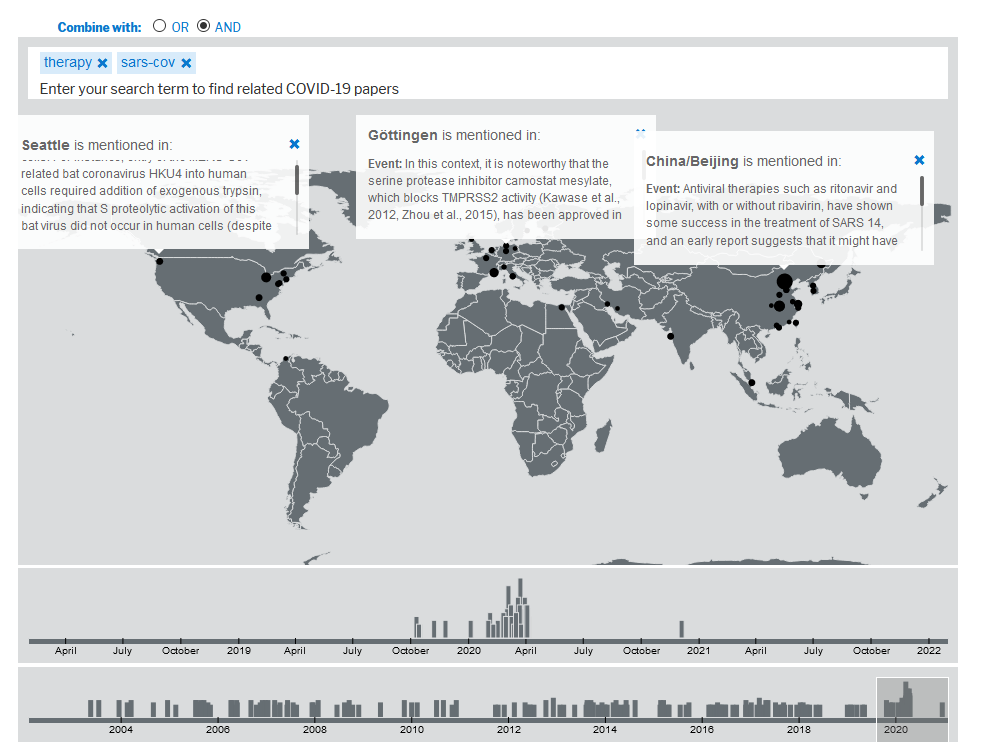

### PMC7118126
 
['A number of nonspecific antiviral drugs, including IFN, lopinavir-ritonavir (HIV protease inhibitors), chloroquine, favipiravir (T-705) and remdesivir (GS-5734), have been used in clinics in China to treat SARS-CoV-2 infection.31 Their in vivo efficacies still require further confirmation.', 'A recent study also found that the binding affinity between ACE2 receptor on the host cell and RBD in S protein of SARS-CoV-2 is more than 10-fold higher than that of SARS-CoV, which may also be associated with the increased infectivity and transmissibility of SARS-CoV-2.12 The conjugation of cholesterol to viral entry inhibitor has been proved to be an effective strategy to enhance the antiviral activity, such as C34 peptide for HIV-1.28 However, the mechanism of this enhancement, especially the role of cholesterol group in the C-terminal tail of entry inhibitor, is still unclear.', 'Fifth, because of its broad-spectrum anti-coronavirus activity, EK1C4 can be used for treatment and prevention of infection by not only SARS-CoV-2, but also other HCoVs.', 'Currently, no specific anti-CoV therapeutics or prophylactics have been used in clinics for treatment or prevention of SARS-CoV-2 infection.', 'In the early outbreak of MERS, we quickly solved the 6-HB fusion core structure formed by MERS-CoV S protein HR1 and HR2 domains and designed the fusion inhibitory peptide HR2P-M2 which proved to be highly effective in blocking its spike protein-mediated membrane fusion and inhibit in vitro MERS-CoV infection.16 The results from animal experiments showed that intranasal application of HR2P-M2 peptide could effectively protect mice from MERS-CoV infection with reduction of virus titers in the lung more than 1000-fold.29 However, the MERS-CoV HR2P-M2 peptide could not inhibit SARS-CoV infection, suggesting that this peptide lacks cross-inhibitory activity against other β-CoVs, such as SARS-CoV and bat SARSr-CoVs.']

 
### PMC7105280
 
['The pharmaceutical interventions found for COVID-19 treatment include human immunoglobulin, interferons, chloroquine, hydroxychloroquine, arbidol, remdesivir, oseltamivir, favipiravir, carrimycin, methylprednisolone, bevacizumab, thalidomide, vitamin C, pirfenidone, bromhexine, fingolimod, danoprevir, ritonavir, darunavir, cobicistat, lopinavir, xiyanping, and traditional Chinese medicines (TCM).', 'Several trials involve lopinavir-ritonavir treatment in comparison with the use of other drugs for COVID-19: arbidol (26,27), carrimycin (28), TCM (34,35), xiyanping (36,37), danoprevir-ritonavir (38) and interferon inhalation (34,38).', 'In this review, we found 24 clinical trials that have already started with the repositioning of more than 20 medicines for COVID-19 treatment, such as human immunoglobulin, interferons, chloroquine, hydroxychloroquine, arbidol, remdesivir, favipiravir, oseltamivir, thalidomide, methylprednisolone, bevacizumab, and TCM.', 'Oseltamivir is also used in a clinical trial with multiple combinations with chloroquine and favipiravir (31), a nucleoside analog that is well-known as a broad-spectrum antiviral drug; it has shown (23) an EC50 of 61.88 μM against SARS-CoV-2 and low toxicity (CC50 >400 μM).', 'Danoprevir is an HCV NS3 protease inhibitor approved in China for the treatment of non-cirrhotic genotype 1b chronic hepatitis C, in combination with ritonavir, peginterferon-a, and ribavirin (41).']


In [ ]:
### ADE associated with coronaviruses ###
for n,m in enumerate(vdfgs['ADE']):
    row = vdfgs['ADE'].iloc[n+1]
    print(row['PMC-ID'])
    print(' ')
    print(' ')
    print(row['SENT'][0:5])
    print(' ')
    print('###################################')
    print(' ')

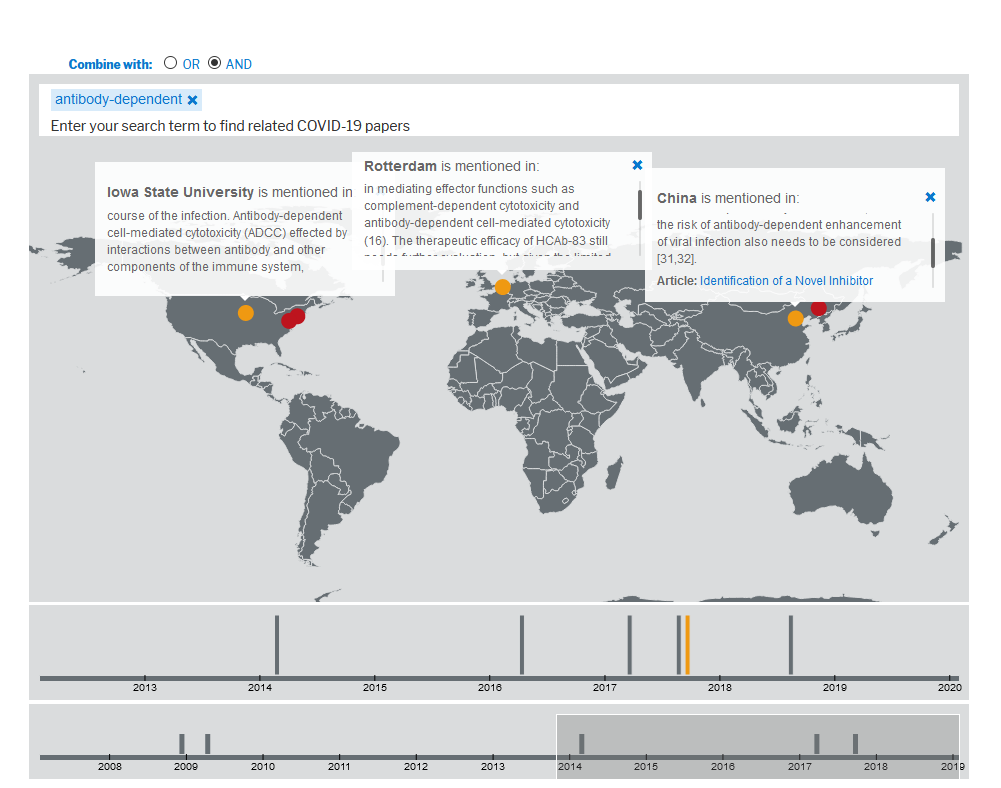

### PMC4822964
 
['Antibody-dependent cell-mediated cytotoxicity (ADCC) effected by interactions between antibody and other components of the immune system, e.g.', '(2006) reported that passive antibody protected neonates against rotavirus and determined that high titers of maternal antibody suppressed effector and memory B-cell responses [43].', 'Since piglets administered concentrated antibody had FFN antibody titers of up to 1:32 at 0 DPI, it may be hypothesized that circulating neutralizing antibodies delivered via intraperitoneal administration may have reduced the level and/or the duration of PEDV viremia and modified the clinical course of the infection.', 'How do the antibody levels and antibody isotypes examined in this experiment relate to those achieved in production settings by feedback, vaccination, or a combination of the two?', 'During PEDV viremia, binding of circulating PEDV antibodies (neutralizing and non-neutralizing) to viral antigenic determinants may have resulted in neutralization, agglutination, and/or complement fixation.']

 
### PMC6082650
 
['Apart from direct neutralization, antibodies may also play a role in mediating effector functions such as complement-dependent cytotoxicity and antibody-dependent cell-mediated cytotoxicity (16).', 'In particular, bone marrow plasma cells are long-lived and are thus suitable for maintaining antibody levels in the serum for an extended period, which plays a significant role in pathogen neutralization and humoral immune responses (40).', 'Recent studies also revealed the importance of long CDR3 sequences from bovine antibodies raised against HIV in cross-neutralization against different viral serotypes (43).', 'HCAb-83 has an Fc domain of human IgG2, which has limited effector function in vivo (17), suggesting that the observed protection in mice could be mainly due to the neutralizing activity.', 'Therefore, additional studies need to evaluate whether the potency of HCAb-83 may be increased further by replacing the IgG2 Fc with the IgG1 Fc or by combination with other antibodies targeting different epitopes.']

 
### PMC6542157
 
['Neutralizing antibodies likely to directly inhibit MERS-CoV entry and/or function through Fc receptor mediated functions such as antibody-dependent cellular cytotoxicity (ADCC) largely through nature killers (NK) cells and antibody-dependent phagocytosis (ADPC) largely through neutrophils.', 'In particular, analysis of sera absorption and isolation of monoclonal antibodies from immunized mice indicate that the protective response can be largely attributed to antibodies targeting to the RBD of the S protein.', 'ChAd3 encoding the Ebola Zaire glycoprotein (ChAd3-EBO-Z) is safe and induces neutralizing antibodies and T cell responses against the Ebola virus in humans [50].', 'Sera absorption analysis and isolation of monoclonal antibodies from immunized mice demonstrate that the observed potent and broad neutralizing activity can be attributed to the antibodies targeting to the RBD of the S protein.', 'Such high and persistent levels of antibody is in great contrast to those induced by other candidate vaccines for which immunogenicity is short-lived and multiple rounds of immunization are required to induce detectable levels of neutralizing antibody or to confer protection against viral challenge [34,38].']


In [ ]:
### Immunity responses to coronaviruses ###
for n,m in enumerate(vdfgs['immunity']):
    row = vdfgs['immunity'].iloc[n]
    print(row['PMC-ID'])
    print(' ')
    print(row['SENT'][0:5])
    print(' ')
    print('###################################')
    print(' ')

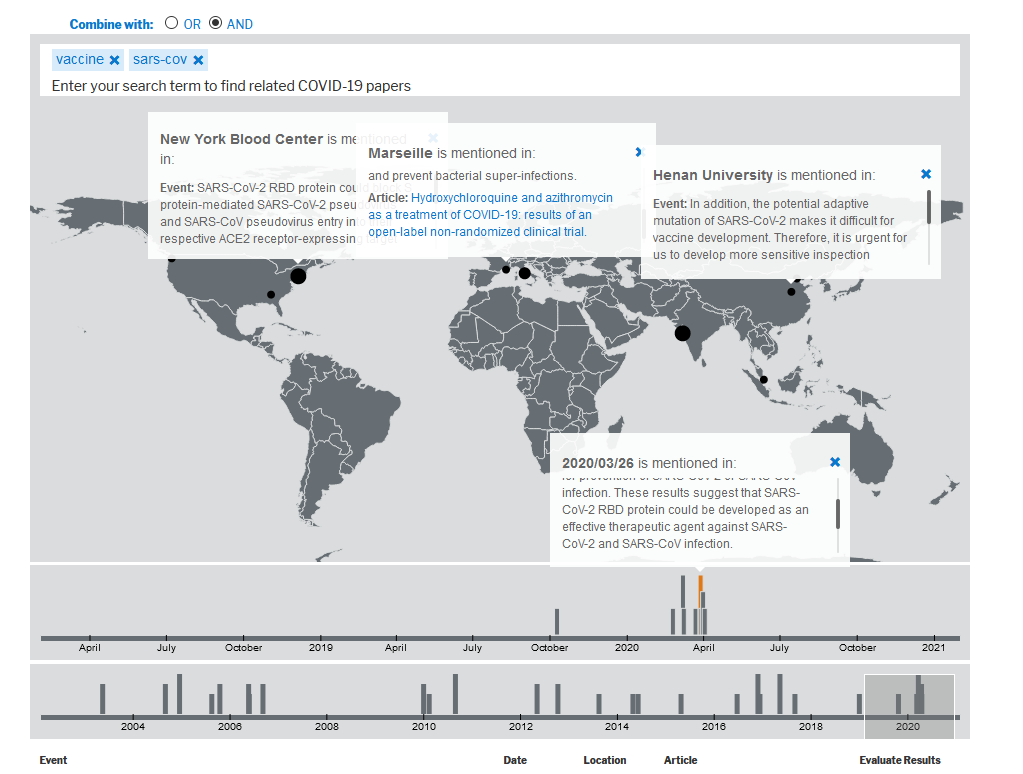

### PMC4747621
 
['These changes were associated with increases in levels of several innate immune molecules and cytokines, including type I, II, and III interferons; ISG15, interleukin 6, interleukin 12p40, interleukin 15, CCL2, CXCL9, and CXCL10.', 'Interestingly, the level of interferon λ, the predominant mucosal interferon in the lung [46], was markedly induced in the lung of MERS-CoV–infected mice.', 'In this setting of severe disease, immunization with VRPs expressing the MERS-CoV S glycoprotein conferred protective immunity.', 'This suggests that, with infection restricted to the lung, mouse innate immunity may successfully overcome virulence factors expressed by MERS-CoV and prevent a lethal outcome.']

 
### PMC7019308
 
['Human cytomegalovirus evades humoral immunity by the degradation of FcRn [30].', 'Reovirus, LPS (a ligand for Toll-like receptor 4 (TLR4) TLR4), IFN-γ, and tumor necrosis factor-alpha (TNF-α) all regulate pIgR and FcRn expression, mainly by the activation of the NF-κB or Janus kinase/signal transducers and activators of transcription (JAK-STAT) JAK-STAT pathway [31,32,33,34].', 'IgA and IgG play a major role in mucosal infection immunity; some cytokines or pathogens have also evolved ways to regulate pIgR and FcRn to facilitate infection [29,30].', 'The down-regulation of FcRn and pIgR by reovirus have been shown in the tracheal mucosa of simian-human immunodeficiency virus/simian immunodeficiency virus (SHIV/SIV)-infected rhesus monkeys [35,36].', 'TGEV-induced FcRn expression by activating NF-κB signaling in porcine small intestinal epithelial (IPEC-J2) cells [19].']

 
### PMC3602451
 
['The Th1-like phenotype is predominantly associated with interleukin-2 (IL-2) and interferon-γ (IFN-γ) [30], [43]–[46]; The Th2-like phenotype, characterized by increased levels of interleukin-4 (IL-4), interleukin-5 (IL-5), and interleukin-6 (IL-6), is associated with improving humoral response and mucosal immune response [21], [38].', 'Their activation causes the secretion of cytokines that advance cellular and humoral immune responses and mediate CTL activity.', 'Changes in serum IFN-γ and IL-4 levels in immunized mice were analyzed.', 'Both the recombinant plasmids pIRES-(TGEV-S1-PEDV-S1) and pIRES-(TGEV-S1-PEDV-S) could elicit in mice cellular immunity, T-cell response as well as humoral response generating CTLs, helper T cells, particularly of Th1 cells, as well as specific neutralizing antibodies against PEDV and TGEV, respectively.', 'They not only may stimulate antibody responses but also the production of helper T cells, which are necessary for the specificity of antibodies and CTLs production.']

 